# Group Project Proposal -- Audit Data

### Introduction

Globally, the frequency and variety of reported fraud are increasing in the financial market. Companies that resort to unfair practices without fear of legal repercussions can have serious economic and social consequences(Nishtha Hooda,Seema Bawa,Prashant Singh Rana,2018). Over the past few decades, some large corporations have gone out of business due to fraud and a huge number of investors suffer from fraud. 

Therefore, Auditors who are devoted to predicting fraudulent firms on the basis of the present and historical risk factors, become more vital. Audit includes the internal audit and external audit. Auditing includes internal auditing and external auditing, what we will research is external auditing, they are independent of any company and are hired to assess whether a company's financial records match its business activities, and to express their opinion about the company Whether there is any action of financial fraud. 

In addition, data science plays an increasingly significant role in audits today, which can provide more robust planning analytics to assist audits, be able to test complete data sets, more comprehensive analysis of audit evidence, and save time performing audit procedures on-site(Maria L. Murphy, CPA, and Ken Tysiac,2015).

Therefore, we choose this database as our project resource and our project purpose is to check whether this data set can help us correctly predict the risk of fraud for every company. We can download audit data.zip from the given webs. The data set we are going to analyze is a classification model which includes a variety of examined risk factors, like past records of, audit office, audit-paras, environmental conditions reports, firm reputation summary, ongoing issues report, profit-value records, loss value records, follow-up reports in the case study.

### Methods

We will conduct our data analysis using classification. The variables/columns we will use are:
1. Sector_score: Historical risk score value of the target unit using analytical procedure
2. PARA_A: Discrepancy found in the planned expenditure of inspection and summary report
3. PARA_B: Discrepancy found in the unplanned expenditure of inspection and summary report B
4. TOTAL: Total discrepancy found in the planned expenditure of inspection and summary report
5. Money_Value: Amount of money involved in misstatements in the past audits
6. Score: Total risk score using an analytical procedure

Firstly, we will create the train / test split, and then split the training data to train / validation. A recipe that specifies the predictors will be created, followed by the nearest_neighbors model specification. After choosing the most optimal K value from cross validation, we will retrain the classifier. Finally, we will evaluate the estimated accuracy of the classifier on the test set. One of the visualization methods we are going to use are scatter plots between every 2 of the predictors to see the correlation between them and how the target class is distributed.

### Preliminary exploratory data analysis

In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

In [2]:
set.seed(1000)
# reading data from the file
url = "https://raw.githubusercontent.com/VYang4/trial.csv/main/trial.csv"
trial <- read_csv(url)
trial |> head(5)

Rows: 776 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (17): Sector_score, PARA_A, SCORE_A, PARA_B, SCORE_B, TOTAL, numbers, Ma...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Sector_score,LOCATION_ID,PARA_A,SCORE_A,PARA_B,SCORE_B,TOTAL,numbers,Marks,Money_Value,MONEY_Marks,District,Loss,LOSS_SCORE,History,History_score,Score,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.89,23,4.18,6,2.50,2,6.68,5,2,3.38,2,2,0,2,0,2,2.4,1
3.89,6,0.00,2,4.83,2,4.83,5,2,0.94,2,2,0,2,0,2,2.0,0
3.89,6,0.51,2,0.23,2,0.74,5,2,0.00,2,2,0,2,0,2,2.0,0
3.89,6,0.00,2,10.80,6,10.80,6,6,11.75,6,2,0,2,0,2,4.4,1
3.89,6,0.00,2,0.08,2,0.08,5,2,0.00,2,2,0,2,0,2,2.0,0


#### Table 1. Sample of dataset with the chosen predictors

In [3]:
# mutating the target column Risk to be a factor
trial <- trial |> mutate(Risk = as_factor(Risk))
# Selecting the nessesary columns 
trial <- select(trial, Sector_score, PARA_A, PARA_B, TOTAL, Money_Value, Score, Risk)
trial <- trial |> drop_na()
trial |> head(5)

Sector_score,PARA_A,PARA_B,TOTAL,Money_Value,Score,Risk
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.89,4.18,2.50,6.68,3.38,2.4,1
3.89,0.00,4.83,4.83,0.94,2.0,0
3.89,0.51,0.23,0.74,0.00,2.0,0
3.89,0.00,10.80,10.80,11.75,4.4,1
3.89,0.00,0.08,0.08,0.00,2.0,0


In [4]:
# Spliting the dataset into 75% training and 25% testing data
trial_split <- initial_split(trial, prop = 0.75, strata = Risk)
trial_train <- training(trial_split)
trial_test <- testing(trial_split) 

#### Table 2. Proportions of the risky/not risky compinies in the dataset. (1 - risky, 0 - not risky)

In [5]:
trial_proportions <- trial_train |>
                      group_by(Risk) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(trial_train))
trial_proportions

Risk,n,percent
<fct>,<int>,<dbl>
0,216,37.24138
1,364,62.75862


#### Table 3. The mean values of the chosen parameters with regard to the target class

In [6]:
mean_statistics <- trial_train |>
              group_by(Risk) |>
              summarize(mean_para_a = mean(PARA_A), mean_para_b = mean(PARA_B),
                        mean_total = mean(TOTAL), mean_money_value = mean(Money_Value),
                        mean_sector_score = mean(Sector_score), mean_score = mean(Score))

mean_statistics

Risk,mean_para_a,mean_para_b,mean_total,mean_money_value,mean_sector_score,mean_score
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.3006944,0.2513157,0.5520102,0.28400,32.47847,2.000000
1,3.8406885,18.8677473,22.6975841,24.27308,13.67192,3.118681


#### Figure 1. Money value vs. Score

Warning message:
“Transformation introduced infinite values in continuous x-axis”


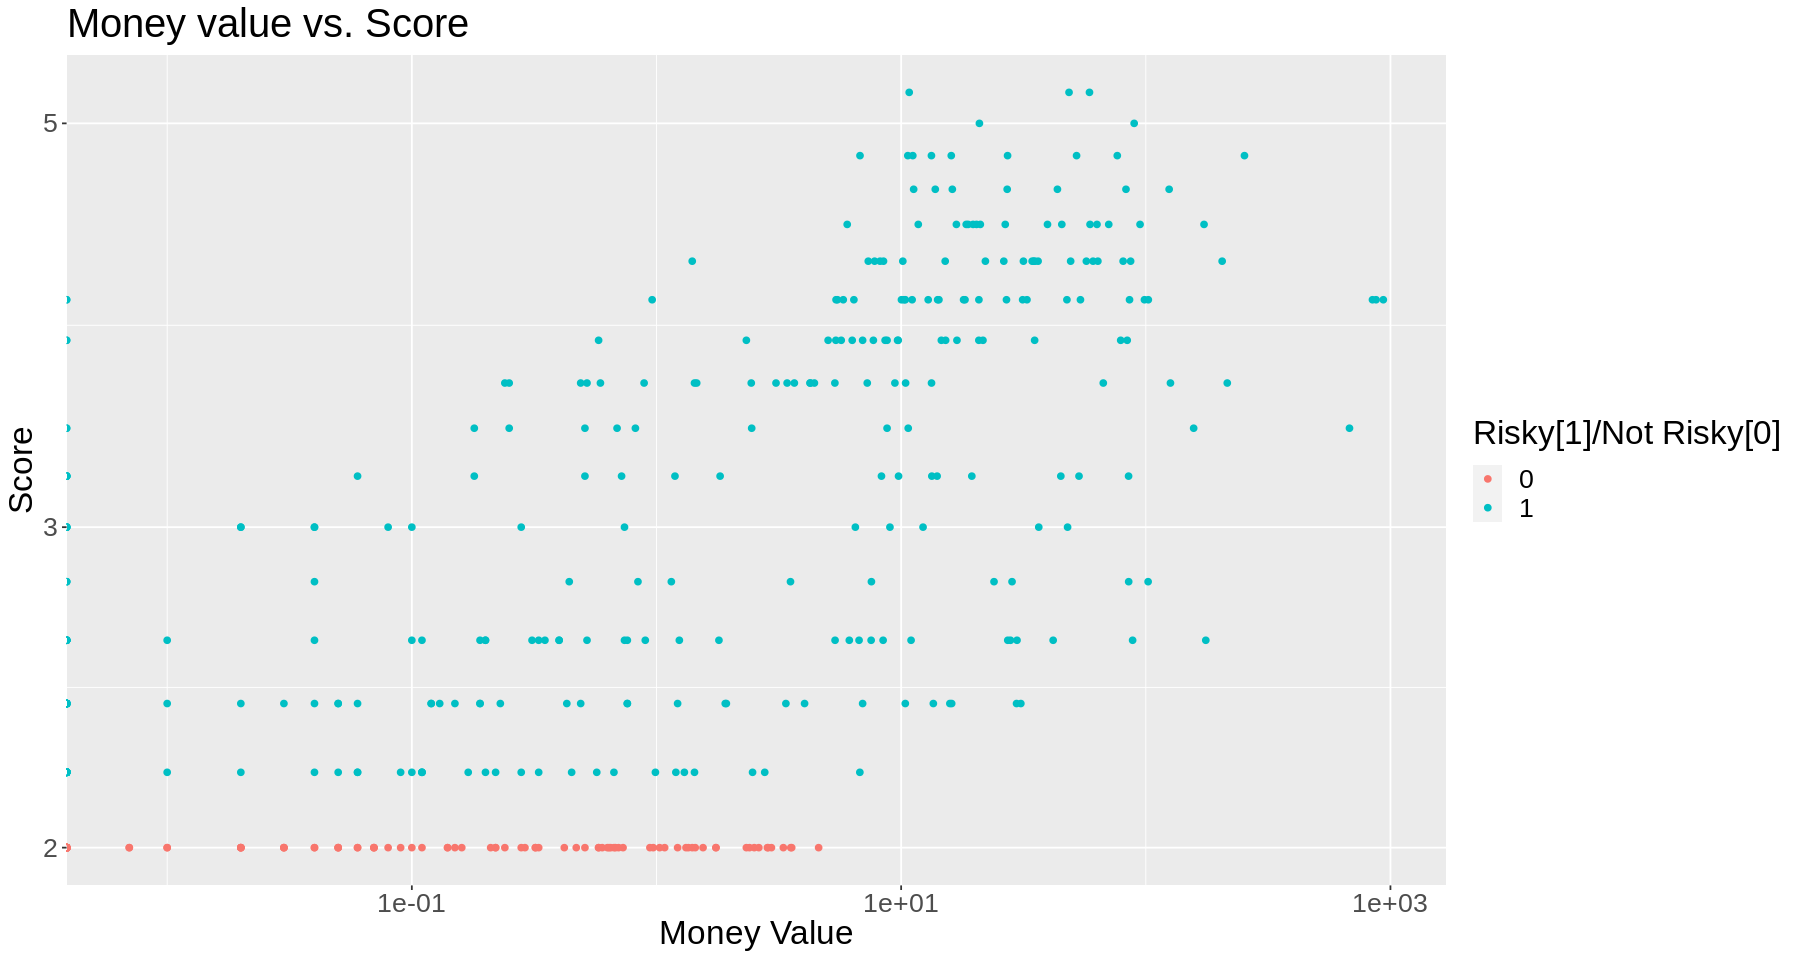

In [7]:
options(repr.plot.width=15, repr.plot.height=8)
money_val_score_chart <- trial_train |>
                           ggplot(aes(x=Money_Value, y=Score, color=Risk)) + 
                           geom_point() + ggtitle("Money value vs. Score") +
                           labs(x="Money Value", y="Score", color="Risky[1]/Not Risky[0]") + scale_x_log10() + scale_y_log10() + theme(text = element_text(size = 20))

money_val_score_chart

#### Figure 2. Parameter A vs. Parameter B 

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


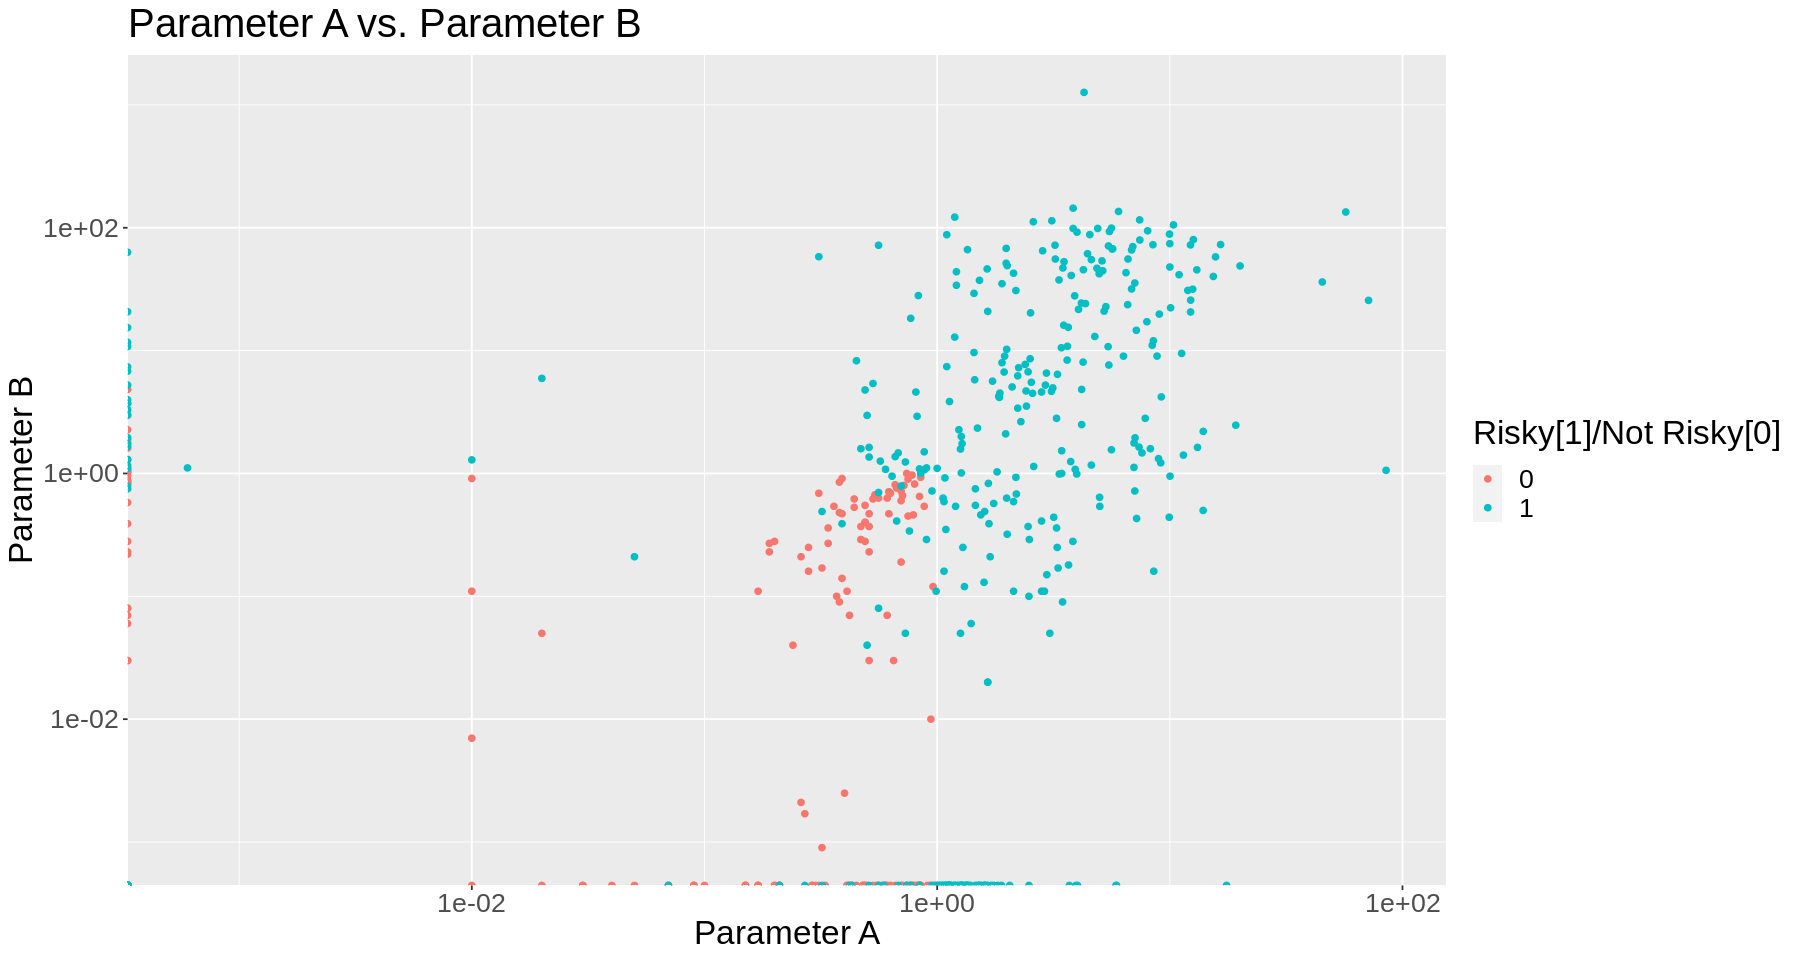

In [8]:
options(repr.plot.width=15, repr.plot.height=8)
para_a_para_b_chart <- trial_train |>
                           ggplot(aes(x=PARA_A, y=PARA_B, color=Risk)) + 
                           geom_point() + ggtitle("Parameter A vs. Parameter B") + 
                           labs(x="Parameter A", y="Parameter B", color="Risky[1]/Not Risky[0]") + scale_x_log10() + scale_y_log10() + theme(text = element_text(size = 20))

para_a_para_b_chart

#### Figure 3. Sector Score vs. Total 

Warning message:
“Transformation introduced infinite values in continuous y-axis”


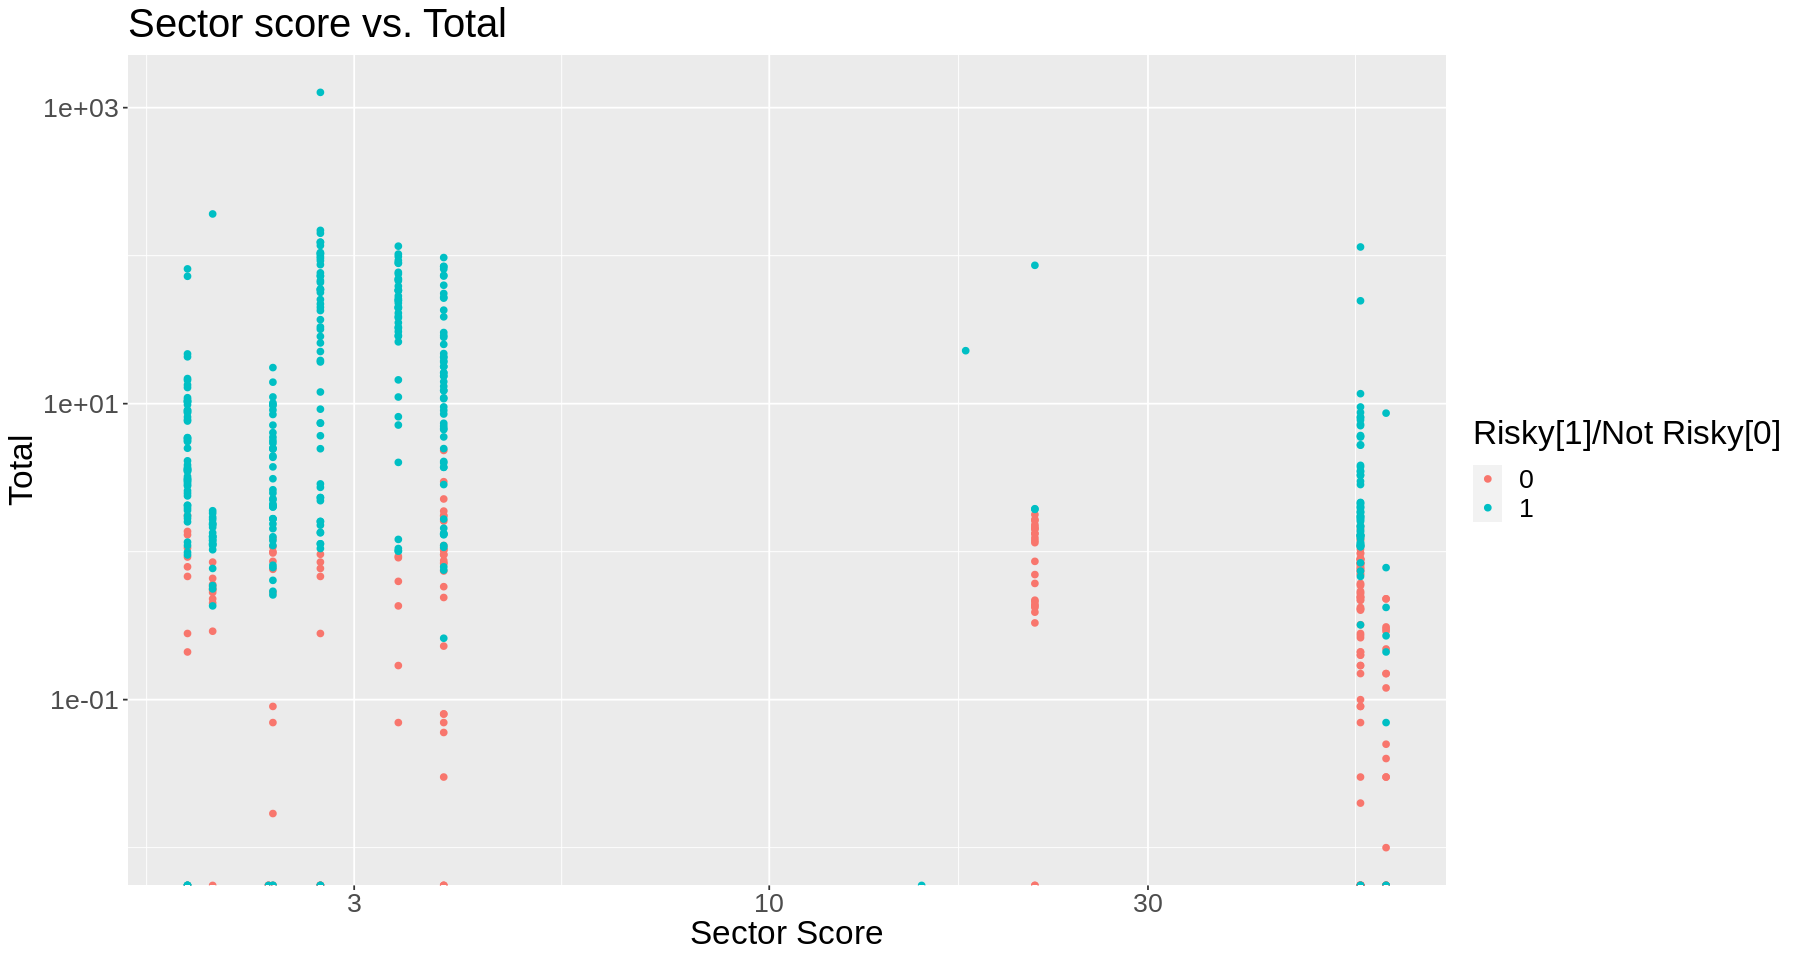

In [10]:
options(repr.plot.width=15, repr.plot.height=8)
sector_score_total_chart <- trial_train |>
                           ggplot(aes(x=Sector_score, y=TOTAL, color=Risk)) +
                           geom_point() + ggtitle("Sector score vs. Total") +
                           labs(x="Sector Score", y="Total", color="Risky[1]/Not Risky[0]") + scale_x_log10() + scale_y_log10() + theme(text = element_text(size = 20))

sector_score_total_chart

### Expected Outcomes and Significance

* We expect to determine whether a firm is risky or not by using the predictors we choose.

* The findings from this study can influence future studies and determine the risk factor of the firm with more accuracy if performed using a large dataset. It can further reduce the risk of losing money if the risk involved is known beforehand. 

* The findings from this project raise the question of whether we can correctly predict if a company is at risk of fraud. This can be used to help clients to choose the appropriate firm which suits their risk appetite.

### Reference

1.Fraudulent Firm Classification: A Case Study of an External Audit, Nishtha Hooda,Seema Bawa,Prashant Singh Rana, Pages 48-64 post online April 06 2018. https://doi.org/10.1080/08839514.2018.1451032

2.Data analytics helps auditors gain deep insight, by Maria L. Murphy, CPA, and Ken Tysiac,April 13 2015. https://www.journalofaccountancy.com/issues/2015/apr/data-analytics-for-auditors.html